# Togo Solar Data: Exploratory Data Analysis

This notebook performs exploratory data analysis on the Togo solar dataset to better understand the data quality, patterns, and relationships between variables.

**Objectives:**
- Profile the data and identify missing values
- Clean the data by handling outliers and missing values
- Perform time series analysis on key solar variables
- Analyze relationships between variables
- Explore environmental factors affecting solar radiation

In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import os

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

# Import custom utility functions
import sys
sys.path.append('..')
from src.utils.utils import (load_data, missing_values_report, detect_outliers, 
                            clean_data, plot_time_series, plot_correlation_heatmap, 
                            plot_scatter, plot_bubble_chart, plot_histogram, save_dataframe)

# Create data directory if it doesn't exist
Path('../data').mkdir(exist_ok=True)

## 1. Data Loading and Initial Inspection

In [2]:
file_path = '../data/togo-dapaong_qc.csv'
df = pd.read_csv(file_path)

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
df.head()

# Check data types
df.info()

Dataset shape: (525600, 19)
Date range: 2021-10-25 00:01:00 to 2022-10-25 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600

Summary Statistics for Numeric Columns:
                           Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-25 12:00:30.000000768     230.555040     151.258469   
min              2021-10-25 00:01:00     -12.700000       0.000000   
25%              2022-01-24 06:00:45      -2.200000       0.000000   
50%              2022-04-25 12:00:30       2.100000       0.000000   
75%              2022-07-25 18:00:15     442.400000     246.400000   
max              2022-10-25 00:00:00    1424.000000    1004.500000   
std                              NaN     322.532347     250.956962   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      116.444352     226.144375     219.568588      27.751788   
min         0.000000       0.000000       0.000000      14.900000   
25%         0.000000       0.000000       0.000000   

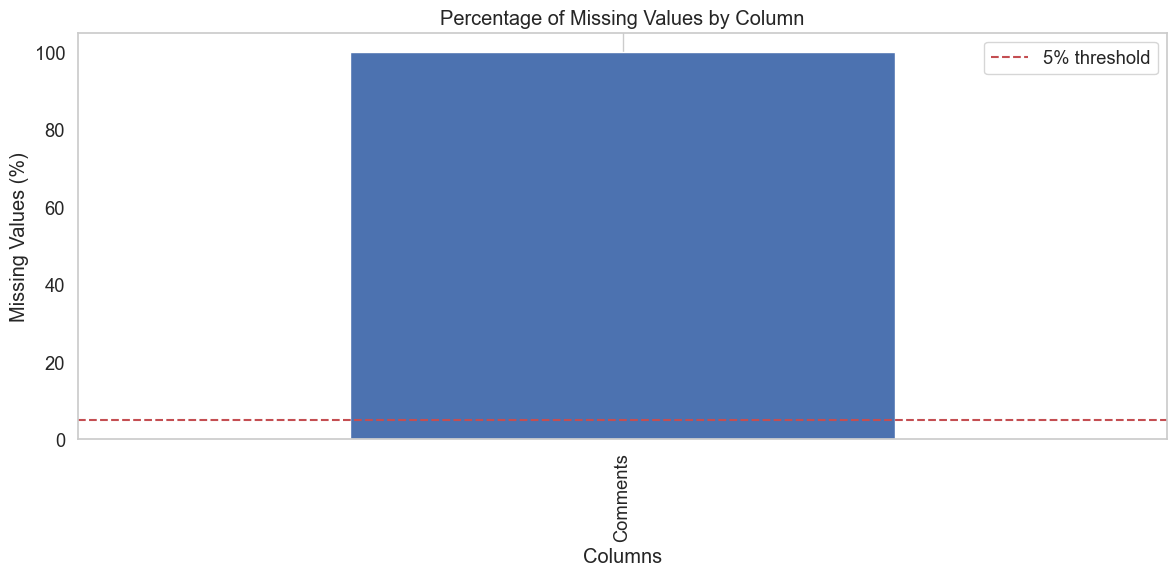

In [3]:
numeric_stats = df.describe()
print("Summary Statistics for Numeric Columns:")
print(numeric_stats)

# Generate missing values report
missing_report = missing_values_report(df)
print("\nMissing Values Report (columns with >5% nulls):")
print(missing_report)

# Create a bar chart of missing values percentage
missing_percentages = df.isna().mean() * 100
missing_percentages = missing_percentages[missing_percentages > 0].sort_values(ascending=False)

if len(missing_percentages) > 0:
    plt.figure(figsize=(12, 6))
    missing_percentages.plot(kind='bar')
    plt.axhline(y=5, color='r', linestyle='--', label='5% threshold')
    plt.title('Percentage of Missing Values by Column')
    plt.ylabel('Missing Values (%)')
    plt.xlabel('Columns')
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()


Number of outliers per column (|Z| > 3):
GHI        305
DNI       1062
DHI       3415
ModA       137
ModB       206
WS        3510
WSgust    3915
dtype: int64


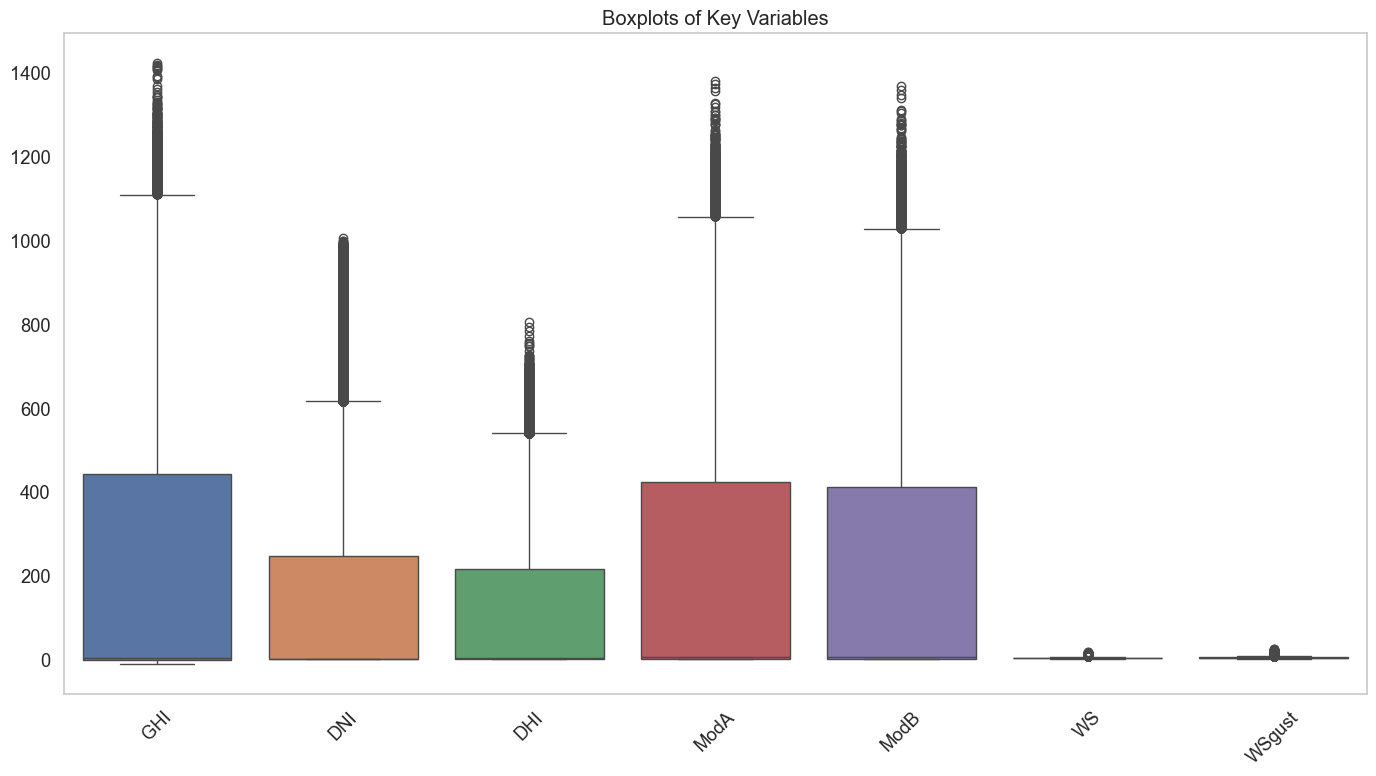


Total rows with at least one outlier: 9251 (1.76%)


In [4]:
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Detect outliers using Z-score method
outliers = detect_outliers(df, key_columns, z_threshold=3)

# Count outliers per column
outlier_counts = outliers.sum()
print("\nNumber of outliers per column (|Z| > 3):")
print(outlier_counts)

# Visualize outliers with boxplots
plt.figure(figsize=(14, 8))
sns.boxplot(data=df[key_columns])
plt.title('Boxplots of Key Variables')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Combine outliers into a single flag per row
df['has_outlier'] = outliers.any(axis=1)
print(f"\nTotal rows with at least one outlier: {df['has_outlier'].sum()} ({df['has_outlier'].mean()*100:.2f}%)")

In [5]:
# Clean data by handling missing values and outliers
columns_to_clean = key_columns + ['Tamb', 'RH', 'WD', 'BP']

# Create a copy of the dataframe for cleaning
df_clean = df.copy()

# Replace extreme outliers with NaN (to be imputed later)
for col in key_columns:
    # Get the z-scores
    z_scores = np.abs(stats.zscore(df_clean[col].dropna()))
    
    # Create a series with the same index as the original column
    z_series = pd.Series(z_scores, index=df_clean[col].dropna().index)
    
    # Get indices where z_score > 3
    outlier_indices = z_series[z_series > 3].index
    
    # Replace outliers with NaN
    df_clean.loc[outlier_indices, col] = np.nan

In [6]:
# Impute missing values with median
df_clean = clean_data(df_clean, columns_to_clean, strategy='median')

# Verify no missing values in cleaned data for key columns
print("\nMissing values in cleaned data:")
print(df_clean[columns_to_clean].isna().sum())

# Save cleaned DataFrame to CSV
clean_data_path = '../data/togo_clean.csv'
save_dataframe(df_clean, clean_data_path)


Missing values in cleaned data:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
Tamb      0
RH        0
WD        0
BP        0
dtype: int64
Data saved to ../data/togo_clean.csv


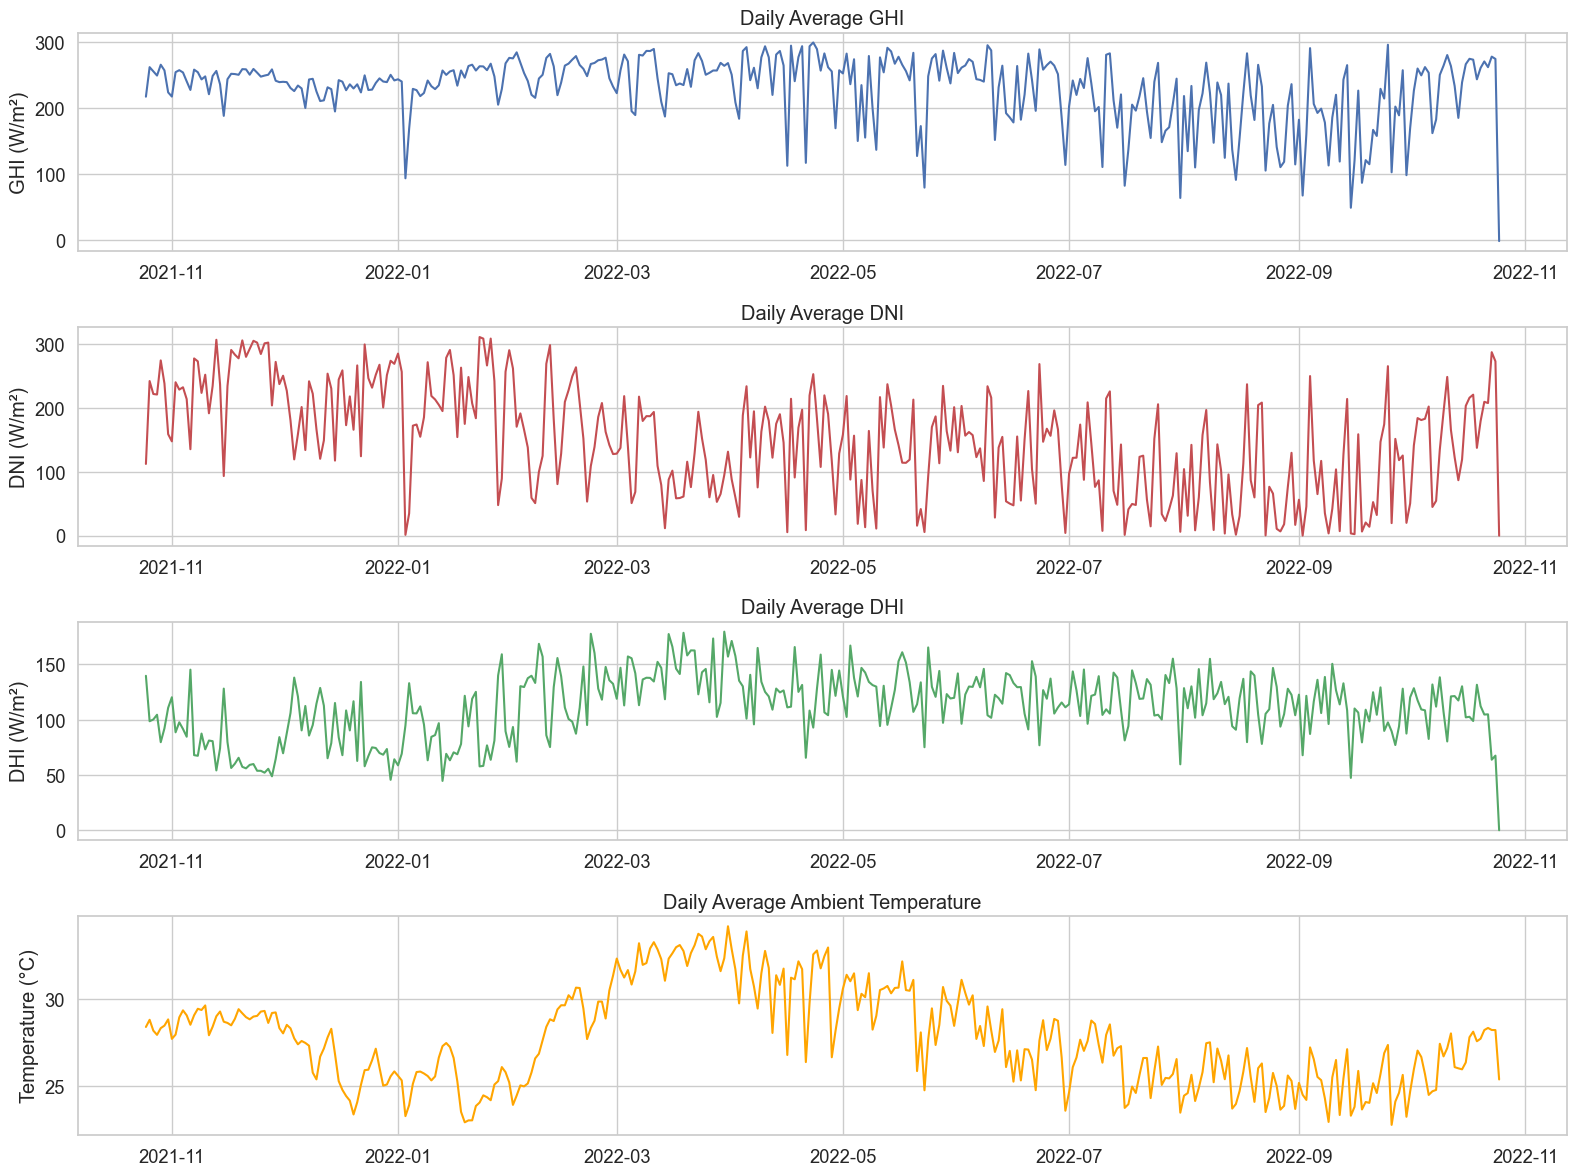

In [7]:
daily_data = df_clean.set_index('Timestamp').resample('D').mean().reset_index()

# Plot GHI, DNI, DHI, Tamb over time
plt.figure(figsize=(16, 12))

# Subplot 1: GHI
plt.subplot(4, 1, 1)
plt.plot(daily_data['Timestamp'], daily_data['GHI'], 'b-')
plt.title('Daily Average GHI')
plt.ylabel('GHI (W/m²)')
plt.grid(True)

# Subplot 2: DNI
plt.subplot(4, 1, 2)
plt.plot(daily_data['Timestamp'], daily_data['DNI'], 'r-')
plt.title('Daily Average DNI')
plt.ylabel('DNI (W/m²)')
plt.grid(True)

# Subplot 3: DHI
plt.subplot(4, 1, 3)
plt.plot(daily_data['Timestamp'], daily_data['DHI'], 'g-')
plt.title('Daily Average DHI')
plt.ylabel('DHI (W/m²)')
plt.grid(True)

# Subplot 4: Ambient Temperature
plt.subplot(4, 1, 4)
plt.plot(daily_data['Timestamp'], daily_data['Tamb'], 'orange')
plt.title('Daily Average Ambient Temperature')
plt.ylabel('Temperature (°C)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Add month and hour columns for additional analysis
df_clean['Month'] = df_clean['Timestamp'].dt.month
df_clean['Hour'] = df_clean['Timestamp'].dt.hour

# Calculate monthly averages
monthly_data = df_clean.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS']].mean().reset_index()

# Plot monthly averages
plt.figure(figsize=(14, 8))

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

[Text(1, 0, 'Jan'),
 Text(2, 0, 'Feb'),
 Text(3, 0, 'Mar'),
 Text(4, 0, 'Apr'),
 Text(5, 0, 'May'),
 Text(6, 0, 'Jun'),
 Text(7, 0, 'Jul'),
 Text(8, 0, 'Aug'),
 Text(9, 0, 'Sep'),
 Text(10, 0, 'Oct'),
 Text(11, 0, 'Nov'),
 Text(12, 0, 'Dec')]

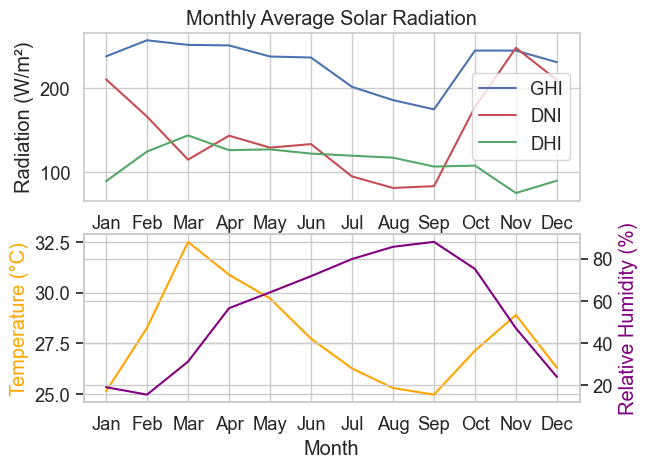

In [9]:
# Plot solar radiation variables
plt.subplot(2, 1, 1)
plt.plot(monthly_data['Month'], monthly_data['GHI'], 'b-', label='GHI')
plt.plot(monthly_data['Month'], monthly_data['DNI'], 'r-', label='DNI')
plt.plot(monthly_data['Month'], monthly_data['DHI'], 'g-', label='DHI')
plt.title('Monthly Average Solar Radiation')
plt.ylabel('Radiation (W/m²)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)

# Plot temperature and humidity
plt.subplot(2, 1, 2)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(monthly_data['Month'], monthly_data['Tamb'], 'orange', label='Temperature')
ax2.plot(monthly_data['Month'], monthly_data['RH'], 'purple', label='Humidity')
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature (°C)', color='orange')
ax2.set_ylabel('Relative Humidity (%)', color='purple')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

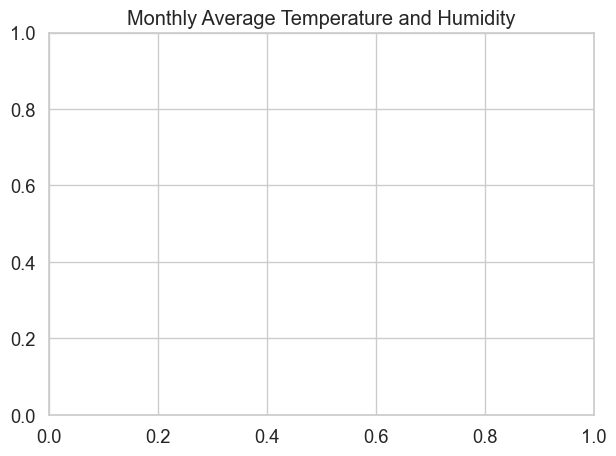

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

In [10]:
# Add both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.title('Monthly Average Temperature and Humidity')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4.3 Diurnal patterns (hourly)
# Calculate hourly averages
hourly_data = df_clean.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS']].mean().reset_index()

# Plot hourly averages
plt.figure(figsize=(14, 8))

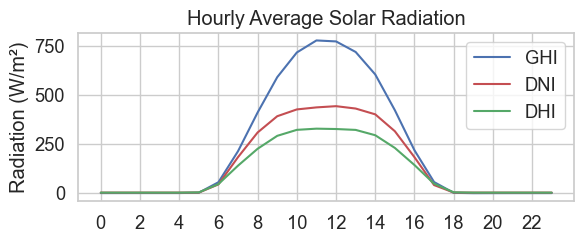

In [11]:
# Plot solar radiation variables
plt.subplot(2, 1, 1)
plt.plot(hourly_data['Hour'], hourly_data['GHI'], 'b-', label='GHI')
plt.plot(hourly_data['Hour'], hourly_data['DNI'], 'r-', label='DNI')
plt.plot(hourly_data['Hour'], hourly_data['DHI'], 'g-', label='DHI')
plt.title('Hourly Average Solar Radiation')
plt.ylabel('Radiation (W/m²)')
plt.xticks(range(0, 24, 2))
plt.legend()
plt.grid(True)

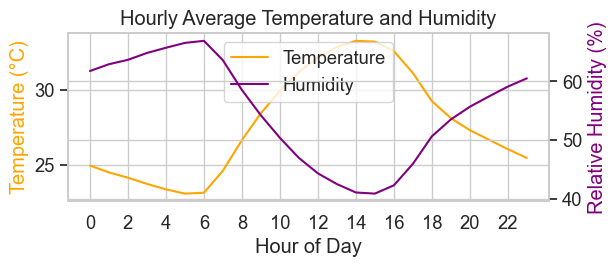

In [12]:
# Plot temperature and humidity
plt.subplot(2, 1, 2)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(hourly_data['Hour'], hourly_data['Tamb'], 'orange', label='Temperature')
ax2.plot(hourly_data['Hour'], hourly_data['RH'], 'purple', label='Humidity')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Temperature (°C)', color='orange')
ax2.set_ylabel('Relative Humidity (%)', color='purple')
ax1.set_xticks(range(0, 24, 2))

# Add both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.title('Hourly Average Temperature and Humidity')
plt.grid(True)
plt.tight_layout()
plt.show()

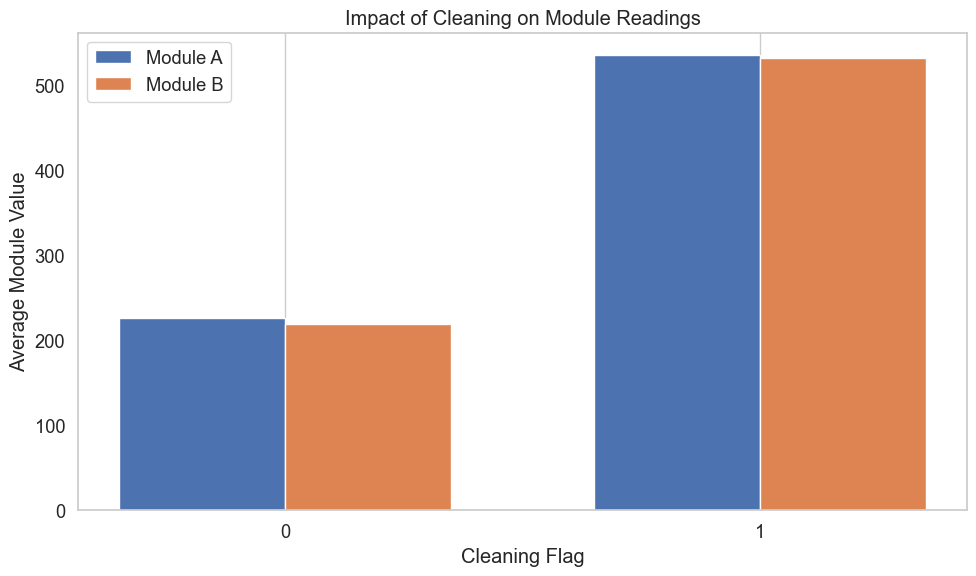

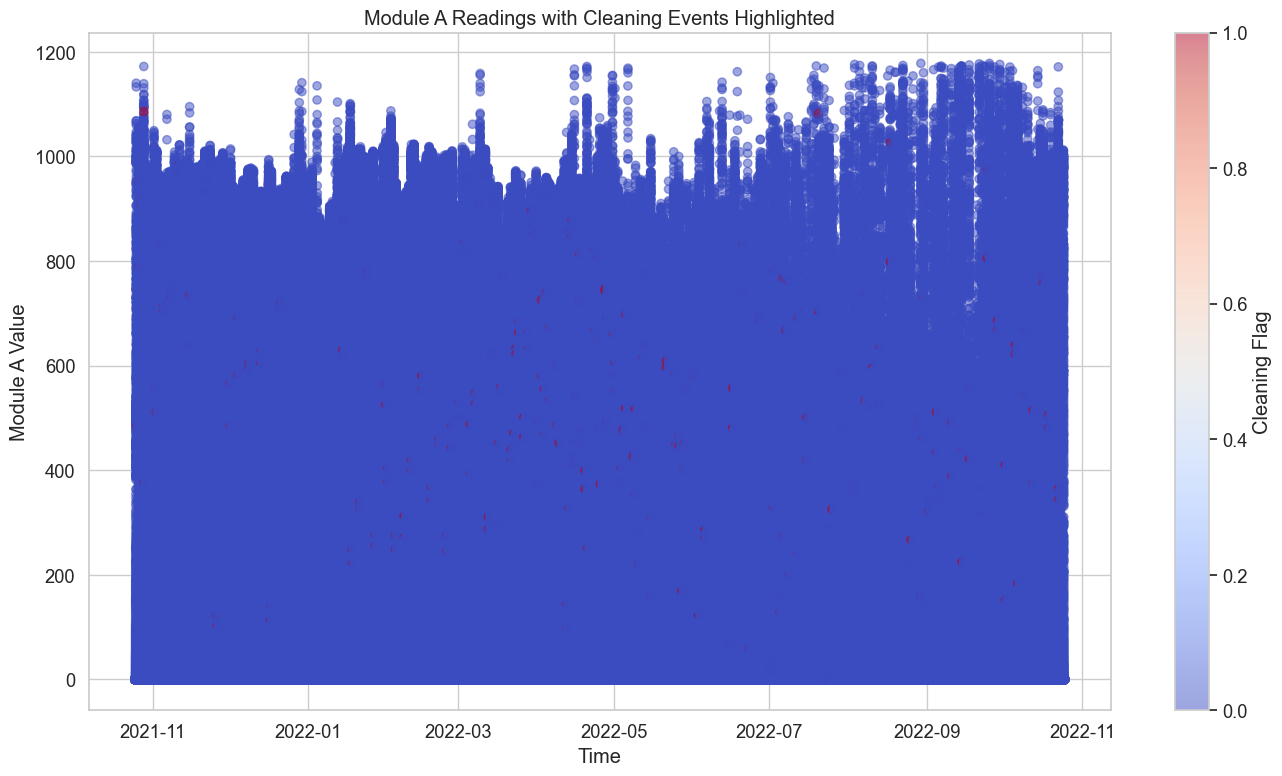

In [13]:
# Group by Cleaning flag and calculate average module temperatures
cleaning_impact = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()

# Plot the impact of cleaning
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(cleaning_impact))

plt.bar(x - bar_width/2, cleaning_impact['ModA'], bar_width, label='Module A')
plt.bar(x + bar_width/2, cleaning_impact['ModB'], bar_width, label='Module B')

plt.xlabel('Cleaning Flag')
plt.ylabel('Average Module Value')
plt.title('Impact of Cleaning on Module Readings')
plt.xticks(x, cleaning_impact['Cleaning'])
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Additional analysis: Time series showing cleaning events
plt.figure(figsize=(14, 8))
plt.scatter(df_clean['Timestamp'], df_clean['ModA'], c=df_clean['Cleaning'], 
           cmap='coolwarm', alpha=0.5, label='ModA')
plt.colorbar(label='Cleaning Flag')
plt.title('Module A Readings with Cleaning Events Highlighted')
plt.xlabel('Time')
plt.ylabel('Module A Value')
plt.grid(True)
plt.tight_layout()
plt.show()

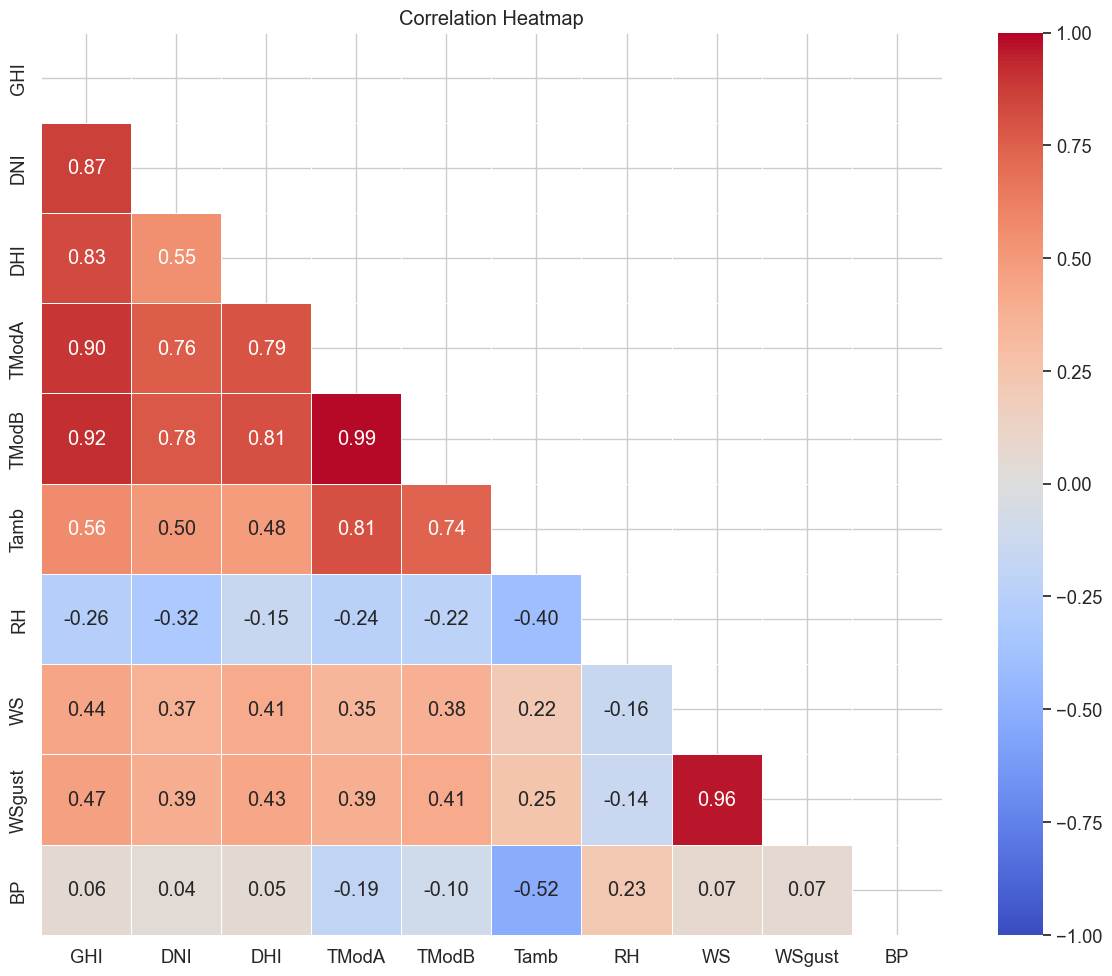

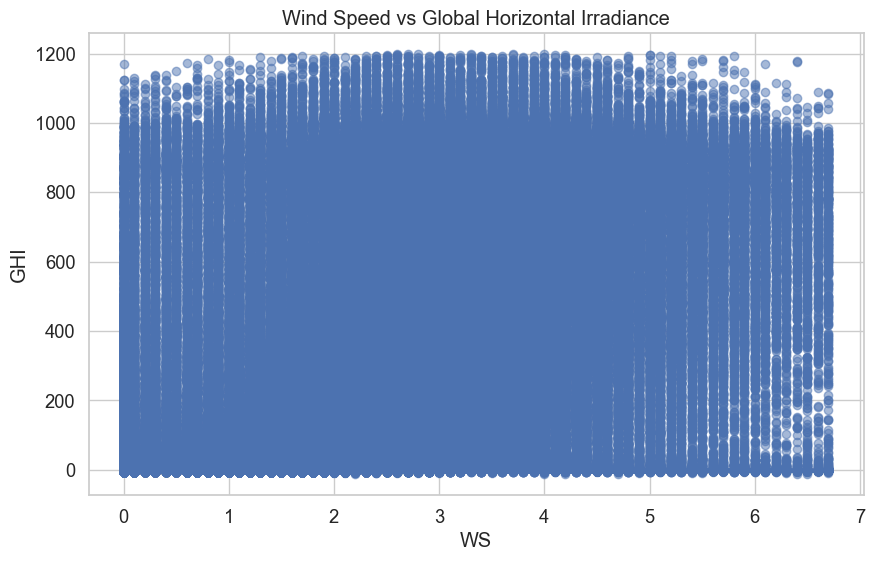

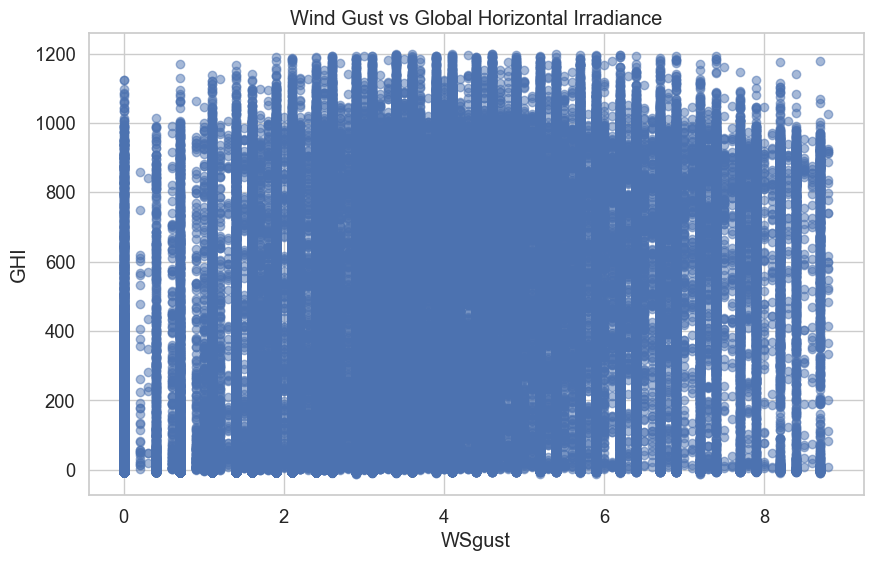

In [14]:
# 6.1 Correlation heatmap
corr_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS', 'WSgust', 'BP']
plot_correlation_heatmap(df_clean, corr_columns)
plt.show()

# 6.2 Scatter plots
# WS vs GHI
plot_scatter(df_clean, 'WS', 'GHI', 'Wind Speed vs Global Horizontal Irradiance')
plt.show()

# WSgust vs GHI
plot_scatter(df_clean, 'WSgust', 'GHI', 'Wind Gust vs Global Horizontal Irradiance')
plt.show()

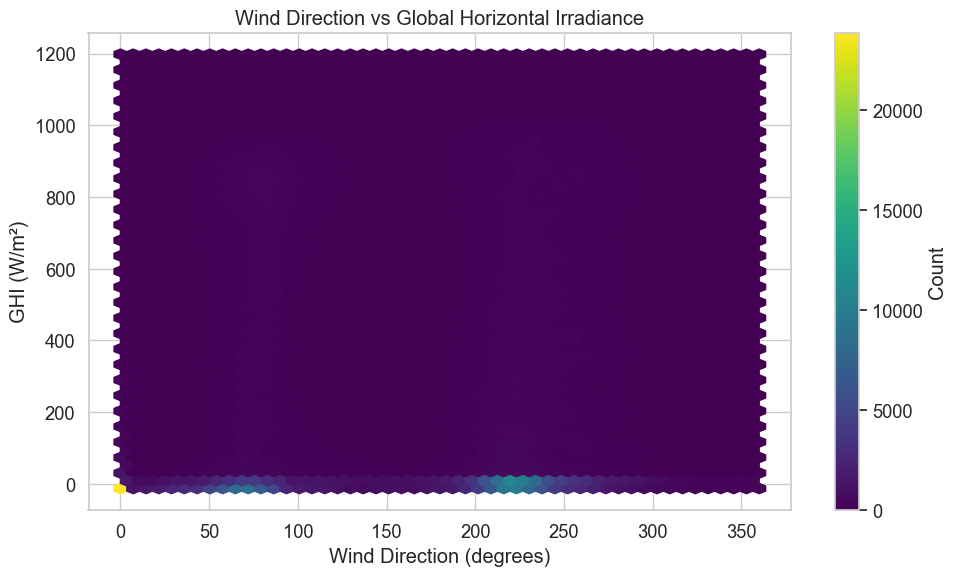

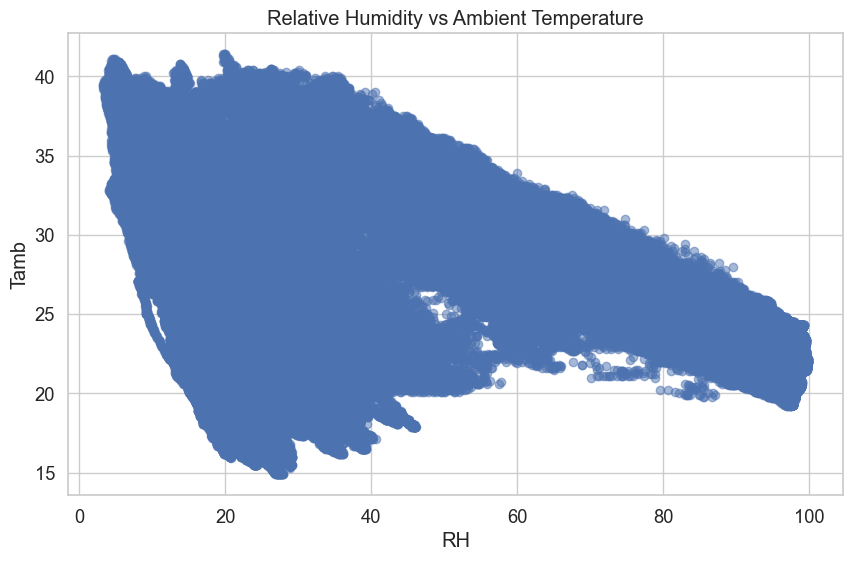

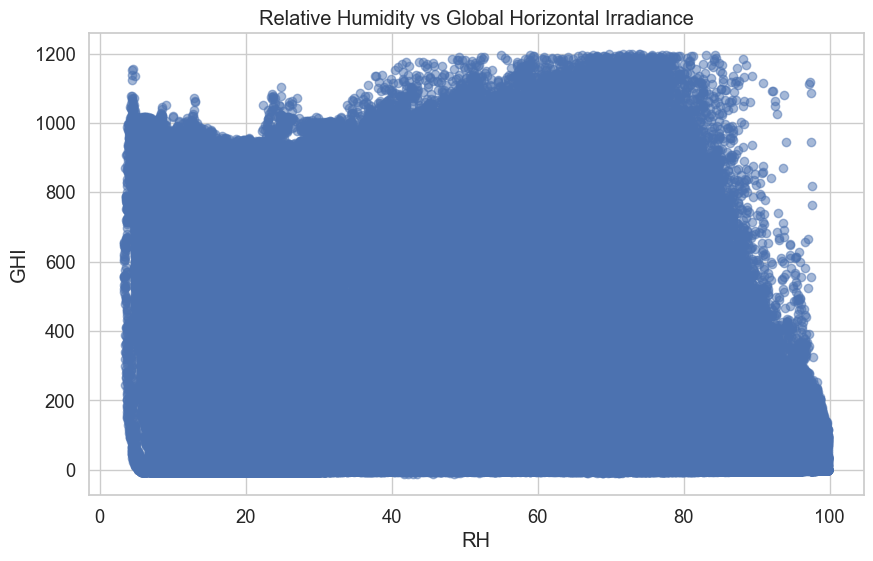

In [15]:
# WD vs GHI (using a hexbin plot for better visualization with circular data)
plt.figure(figsize=(10, 6))
plt.hexbin(df_clean['WD'], df_clean['GHI'], gridsize=50, cmap='viridis')
plt.colorbar(label='Count')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('GHI (W/m²)')
plt.title('Wind Direction vs Global Horizontal Irradiance')
plt.grid(True)
plt.tight_layout()
plt.show()

# RH vs Tamb
plot_scatter(df_clean, 'RH', 'Tamb', 'Relative Humidity vs Ambient Temperature')
plt.show()

# RH vs GHI
plot_scatter(df_clean, 'RH', 'GHI', 'Relative Humidity vs Global Horizontal Irradiance')
plt.show()

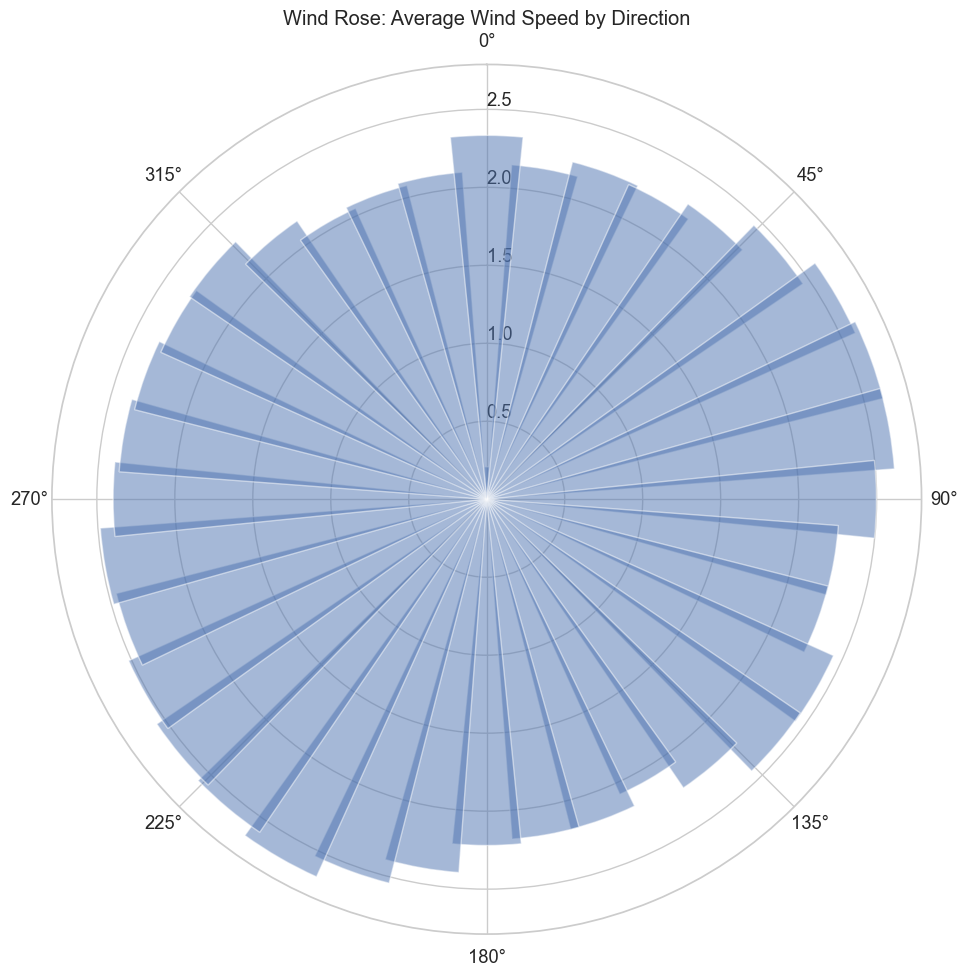

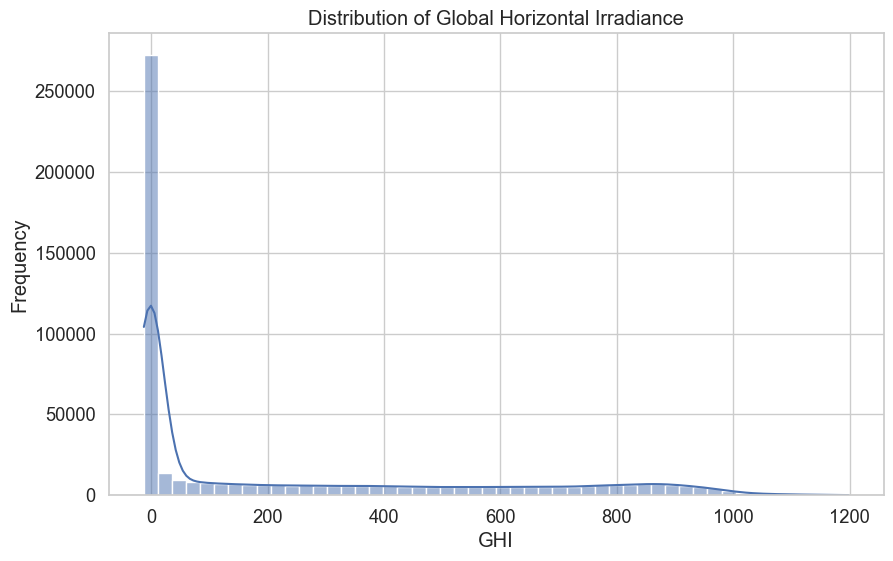

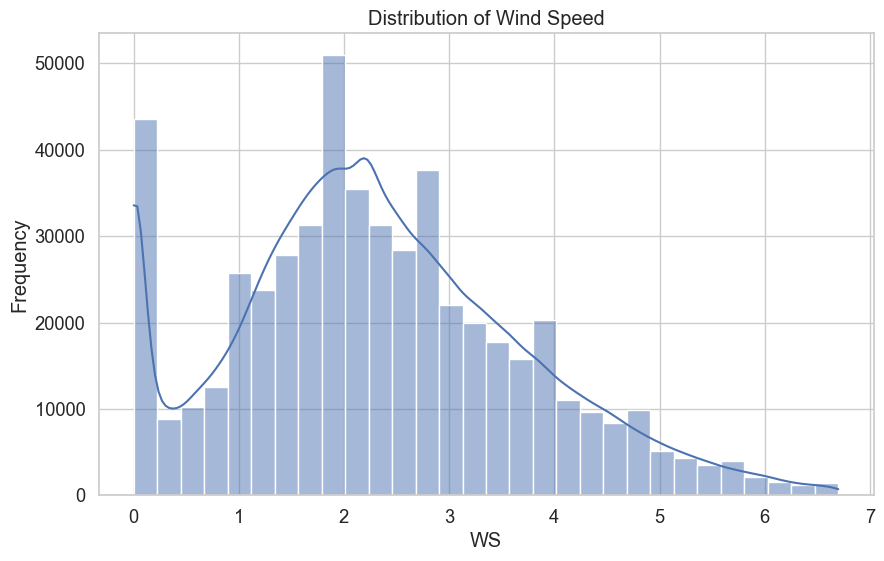

In [16]:
# Group by wind direction (rounded to nearest 10 degrees)
df_clean['WD_rounded'] = (df_clean['WD'] // 10 * 10)
wind_rose_data = df_clean.groupby('WD_rounded')['WS'].mean().reset_index()

# Create wind rose plot
plt.figure(figsize=(10, 10), facecolor='white')
ax = plt.subplot(111, polar=True)
theta = np.radians(wind_rose_data['WD_rounded'])
radii = wind_rose_data['WS']
bars = ax.bar(theta, radii, width=0.2, bottom=0, alpha=0.5)

# Set the direction labels
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)  # Clockwise
ax.set_rlabel_position(0)
ax.set_title('Wind Rose: Average Wind Speed by Direction')
plt.tight_layout()
plt.show()

# 7.2 Histograms
# GHI histogram
plot_histogram(df_clean, 'GHI', bins=50, title='Distribution of Global Horizontal Irradiance')
plt.show()

# Wind Speed histogram
plot_histogram(df_clean, 'WS', bins=30, title='Distribution of Wind Speed')
plt.show()

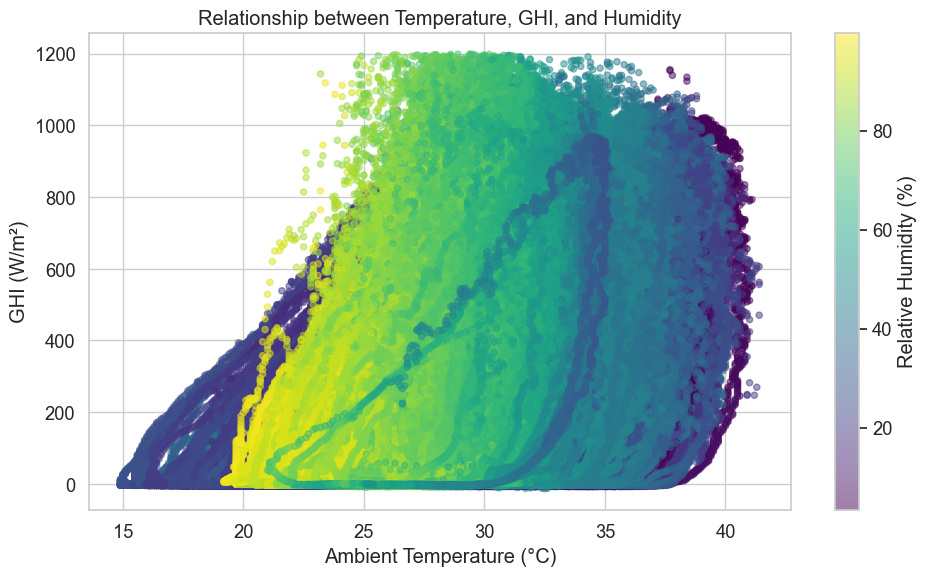

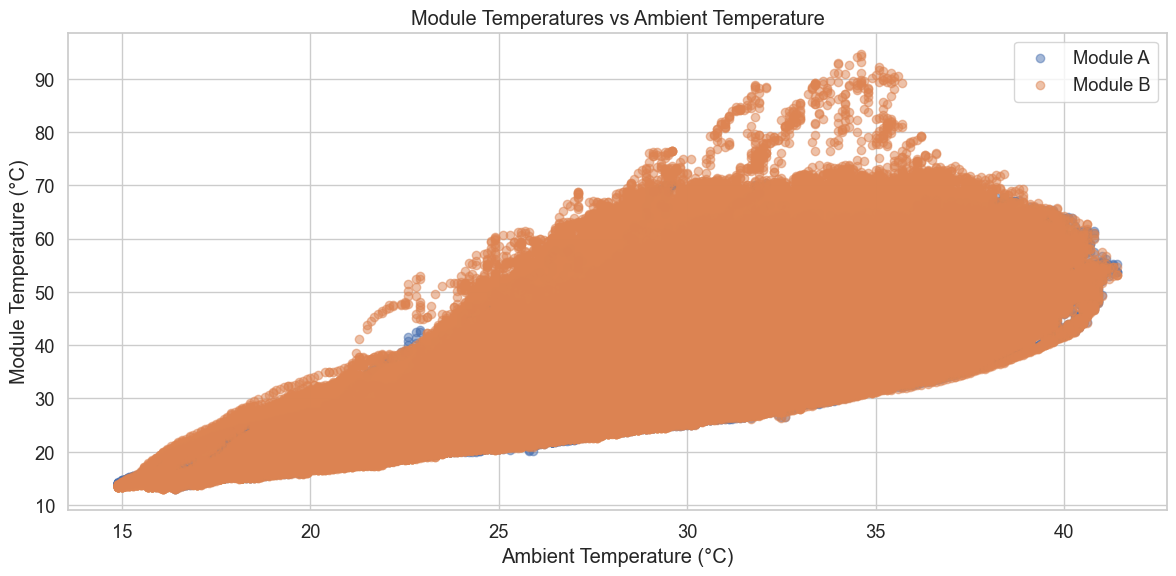

In [17]:
# Examine relationship between RH, temperature and GHI
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df_clean['Tamb'], df_clean['GHI'], c=df_clean['RH'], 
                    cmap='viridis', alpha=0.5, s=20)
plt.colorbar(scatter, label='Relative Humidity (%)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('Relationship between Temperature, GHI, and Humidity')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8.1 Additional temperature analysis: TModA, TModB vs Tamb
plt.figure(figsize=(12, 6))
plt.scatter(df_clean['Tamb'], df_clean['TModA'], alpha=0.5, label='Module A')
plt.scatter(df_clean['Tamb'], df_clean['TModB'], alpha=0.5, label='Module B')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('Module Temperature (°C)')
plt.title('Module Temperatures vs Ambient Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()